## Imports

In [1]:
import datetime
import functools
import os

import numpy as np
import pandas as pd

import scipy.stats

import matplotlib.pyplot as plt
import matplotlib
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['text.usetex'] = True

from lvml.experiment import *

## Load analysis files

In [2]:
from glob import glob
import pickle

selected_seed=1
n_runs = 10
get_seed = lambda f: int(f.split('_')[-1].split('.')[0])

result_files = sorted(glob('./output/results_df_*.csv.zip'), key=get_seed)
results_df_combined = pd.concat([
    pd.read_csv(f).assign(seed=get_seed(f))
    for f in result_files[:n_runs]
])
safety_analysis_files = sorted(glob('./output/safety_*.pkl'), key=get_seed)
safety_res_all = {
    get_seed(f): pickle.load(open(f,'rb'))
    for f in safety_analysis_files[:n_runs]
}

results_df = pd.read_csv(f'./output/results_df_{selected_seed}.csv.zip')
optimizer_variations_results_df = pd.read_csv(f'./output/sensitivity_df_{selected_seed}.csv.zip')
threshold_res = pickle.load(open(f'./output/safety_{selected_seed}.pkl','rb'))

## Prepare plots

In [3]:
selected_simulator = 'discrete'
selected_kappa = 0.5,
selected_predictor = 'linear_regression'
selected_safety_threshold_high = 16
selected_safety_threshold_low = 14

In [4]:
myopic_means = (
    results_df_combined
    .query('simulator=="discrete" and policy=="myopic" and predictor=="linear_regression" and kappa==@selected_kappa')
    .groupby('seed')
    ['rate']
    .mean()
)

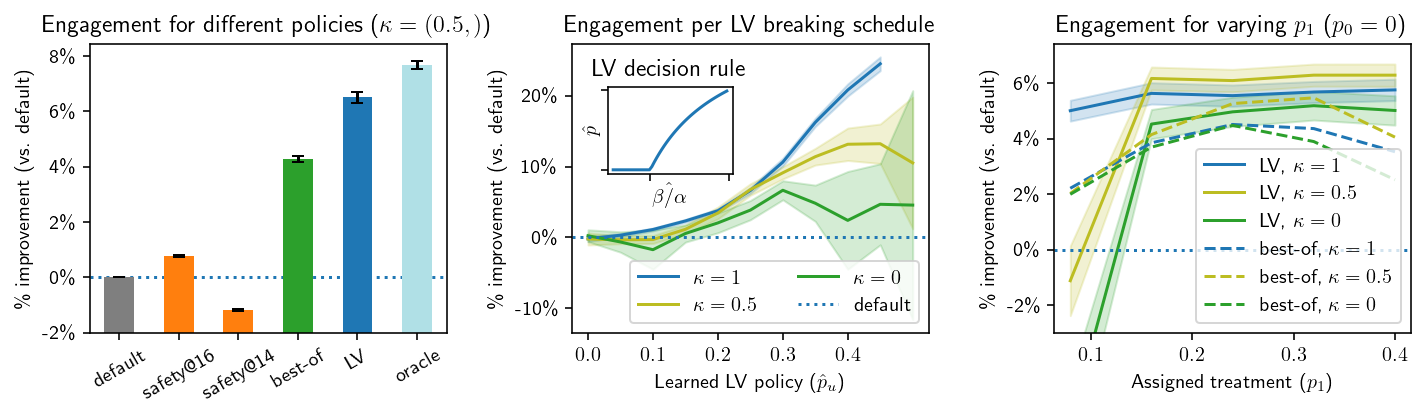

In [5]:
fig,axs=create_fig(1,3,tight_layout=dict(w_pad=2))

kappa_colors={
    ('lv_engagement',1.0): 'tab:blue',
    ('lv_engagement',0.5): 'tab:olive',
    ('lv_engagement',0.0): 'tab:green',
    ('argmax',1.0): 'tab:red',
    ('argmax',0.5): 'tab:pink',
    ('argmax',0.0): 'tab:orange',
}

bar_plot_config={
    'default': ((selected_predictor,'myopic'), 'tab:gray', ''),
    f'safety@{selected_safety_threshold_high}': (('safety',selected_safety_threshold_high), 'tab:orange', ''),
    f'safety@{selected_safety_threshold_low}': (('safety',selected_safety_threshold_low), 'tab:orange', ''),
    'best-of': ((selected_predictor,'argmax'), 'tab:green', ''),
    'LV': ((selected_predictor,'lv_engagement'), 'tab:blue', ''),
    'oracle': (('oracle','lv_engagement'), 'powderblue', ''),
}

confidence_interval = lambda mu, std, count: scipy.stats.norm.interval(
    0.95,
    loc=mu,
    scale=std/np.sqrt(count),
)

ax=axs[0]
prediction_policy_comparison_df = (
    results_df_combined
    .query('simulator==@selected_simulator and kappa==@selected_kappa')
    .pivot('user_ind',['predictor','policy','seed'],'rate')
    .mean()
    .pipe(lambda s: s/s.loc[(selected_predictor,'myopic',slice(None))])
    .unstack()
    .apply(
        lambda row: pd.Series(
            {
                'mean': row.mean(),
                'yerr': confidence_interval(row.mean(), row.std()+1e-9, row.count())[1]-row.mean()
            }
        ),
        axis=1,
    )
)

safety_df = (
    pd.DataFrame(safety_res_all)
    .apply(lambda s: s.map(lambda arr: arr.mean()/myopic_means.loc[s.name]))
    .apply(
        lambda row: pd.Series(
            {
                'mean': row.mean(),
                'yerr': confidence_interval(row.mean(), row.std()+1e-9, row.count())[1]-row.mean()
            }
        ),
        axis=1,
    )
    .reset_index()
    .assign(policy='safety')
    .set_index(['policy','index'])
    # .pipe(lambda df: df.set_index([('safety',x) for x in df.index]))
)

barplot_comparison_df=pd.concat([prediction_policy_comparison_df,safety_df])

(
    barplot_comparison_df
    .loc[[t[0] for t in bar_plot_config.values()]]
    .pipe(lambda df: df['mean'].plot.bar(
        ax=ax,
        color=[t[1] for t in bar_plot_config.values()],
        hatch=[t[2] for t in bar_plot_config.values()],
        yerr=df['yerr'],
        capsize=3,
    ))
)
ax.axhline(1,linestyle=':',zorder=-1)
ax.set(
    ylim=(0.98,1+(barplot_comparison_df['mean'].max()-1)*1.1),
    xticklabels=[n for n in bar_plot_config],
)
ax.xaxis.set_tick_params(rotation=30)
ax.set(
    title=f'Engagement for different policies ($\kappa={selected_kappa}$)',
    xlabel=None,
)
ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x,pos: f'{round((x-1)*100)}\%'))


#
# Engagement vs. p
#

ax=axs[1]
i=0
for selected_kappa in [1.0,0.5,0.0]:
    (
        results_df
        .query('simulator==@selected_simulator and kappa==@selected_kappa and predictor==@selected_predictor')
        .pipe(lambda df: pd.concat(
            [
                (
                    df
                    .pivot('user_ind','policy','rate')
                    .apply(lambda row: row['lv_engagement']/(row['myopic']+1e-5)-1,axis=1)
                    .apply(lambda s: s*100)
                    .rename('gain')
                ),
                (
                    df
                    .query('policy=="lv_engagement"')
                    .set_index('user_ind')
                    ['p_fb']
                ),
            ],
            axis=1,
        ))
        .query('p_fb>1e-5')
        .assign(
            p_group=lambda df: quantize(df['p_fb'], res=0.05)
        )
        .groupby('p_group')
        ['gain']
        .agg([
            ('mean', 'mean'),
            ('ci', lambda s: confidence_interval(s.mean(), s.std(), s.count())),
        ])
        .pipe(lambda df: [
            df['mean'].plot.line(
                ax=ax,
                label=f'$\kappa={selected_kappa:.1g}$',
                color=kappa_colors[('lv_engagement',selected_kappa)],
            ),
            ax.fill_between(
                df.index, 
                df['ci'].map(lambda t: t[0]),
                df['ci'].map(lambda t: t[1]),
                alpha=0.2,
                color=kappa_colors[('lv_engagement',selected_kappa)],
            )
        ])
    )
    i+=1

ax.axhline(0, linestyle=':', label='default')
ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x,pos: f'{round(x)}\%'))
ax.set(
    title='Engagement per LV breaking schedule',
    xlabel=r'Learned LV policy ($\hat{p}_u$)',
    xticks=np.arange(0,0.5,0.1)
)

ax.legend(
    loc='lower right',
    ncol=2,
)


axins = ax.inset_axes([0.1, 0.55, 0.35, 0.3])
ba_theory_vec = np.linspace(1,4)[1:-1]
ab_theory_vec = 1/ba_theory_vec
axins.plot(ba_theory_vec, p_opt_f(ab_theory_vec))
axins.set(
    title='LV decision rule',
    xlabel=r'$\hat{\beta/\alpha}$',
    ylabel=r'$\hat{p}$',
)
plt.setp(axins.get_xticklabels(), visible=False)
plt.setp(axins.get_yticklabels(), visible=False)


#
# Sensitivity
#

ax=axs[2]
i=0
for selected_policy, display_name in [('lv_engagement','LV'), ('argmax','best-of')]:
    for selected_kappa in [1.0,0.5,0.0]:
        color = kappa_colors[('lv_engagement',selected_kappa)]
        linestyle = '-' if selected_policy=='lv_engagement' else '--'
        (
            optimizer_variations_results_df
            .query('predictor=="linear_regression" and mode=="two-treatment" and kappa==@selected_kappa')
            .pivot(
                ['p1','user_ind'],
                'policy',
                'rate',
            )
            .apply(lambda row: row/row['myopic']-1, axis=1)
            .apply(lambda s: s*100)
            [selected_policy]
            .groupby(level=0)
            .agg([
                ('mean', 'mean'),
                ('ci', lambda s: confidence_interval(s.mean(), s.std(), s.count())),
            ])
            # .swaplevel(axis=1)
            # .stack()
            .pipe(lambda df: [
                df['mean'].plot.line(
                    ax=ax,
                    label=f'{display_name}, $\kappa={selected_kappa:.1g}$',
                    color=color,
                    linestyle=linestyle,
                ),
                ax.fill_between(
                    df.index, 
                    df['ci'].map(lambda t: t[0]),
                    df['ci'].map(lambda t: t[1]),
                    alpha=0.2,
                    color=color,
                ) if selected_policy=='lv_engagement' else None
            ])
        )
        i+=1

ax.axhline(0,linestyle=':')
ax.legend()
ax.set(
    title='Engagement for varying $p_1$ ($p_0=0$)',
    xlabel='Assigned treatment ($p_1$)',
    ylabel=r'\% improvement - engagement',
    ylim=(-3,None),
)
ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x,pos: f'{round(x)}\%'))

for i,ax in enumerate(axs):
    ax.set(
        ylabel=r'\% improvement (vs. default)',
    )
    
fig.download('movielens_experiment.pdf')